# Final Project - Python

Luke Sturgeon  
Stat 517-01  
Due Date: 12/11/2018

## Classification by Regression/Clustering and Continuous Variable Prediction  

Two values were most important to be able to predict. "tot_exper" is the number of years a miner has worked within the industry, not just at that job, before they were injured. If we can accurately predict this given the other variables within the dataset, we can predict the rate of injury for miners of a certain experience if they meet the criteria of the other variables within the dataset. "days_lost" is a proxy for the degree of injury. A miner is only excused from work if the injury is significant enough to prevent them from working safely. Only serious injuries are responsible for this. The mining culture is built on pride, a typical miner won't take the day off unless absolutely necessary, possibly skewing this value in the direction of less serious accidents being reported. Another issue with this metric is that if an accident is fatal, the "days_lost" variable is reported as 0 as well, since, technically, they aren't missing any days of work. Ever again.

We start with importing the necessary packages and data for EDA before diving into the classification.

## The Set Up  
The following code will be used in most of the procedures for Question 1 and 2

In [7]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import scale
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
surface_fatigue = pd.read_csv("https://www.dropbox.com/s/t16fkmvgxh0p8dc/dayslost.csv?dl=1")
surface_fatigue = surface_fatigue.drop('Unnamed: 0',axis=1)
surface_fatigue = surface_fatigue.drop('operator_id',axis=1)
surface_fatigue.head()

,controller_name,operator_name,subunit,cal_yr,cal_qtr,accident_time,degree_injury,fips_state_cd,mining_equip,shift_begin_time,...,occupation,activity,injury_source,nature_injury,inj_body_part,schedule_charge,days_restrict,days_lost,trans_term,immed_notify
0,Roger Krause,Krause Bros Construction,"STRIP, QUARY, OPEN PIT",2012,2,1420,DAYS RESTRICTED ACTIVITY ONLY,38,"Front-end loader, Tractor-shovel, Payloader, H...",700,...,"Laborer, Blacksmith, Bull gang, Parts runner, ...",Observe operations,"CHAIN,ROPE,CABLE-NT CONVY","CONTUSN,BRUISE,INTAC SKIN",BACK (MUSCLES/SPINE/S-CORD/TAILBONE),0,4,0,N,NO VALUE FOUND
1,Titan Cement Company S A,"Roanoke Cement Co., LLC",MILL OPERATION/PREPARATION PLANT,2012,2,1100,DAYS AWAY FROM WORK ONLY,51,"Front-end loader, Tractor-shovel, Payloader, H...",700,...,"Ledgeman/hand, Quarry man",Getting on or off equipment,SURFACE MINING MACHINES,"FRACTURE,CHIP",LOWER LEG/TIBIA/FIBULA,0,0,1,N,NO VALUE FOUND
2,Kathy L Dimmerling,Christman Quarry,"STRIP, QUARY, OPEN PIT",2007,1,1130,DAYS AWAY FROM WORK ONLY,39,NO VALUE FOUND,700,...,Haul/Off road/Coal/Ore/Pit/Quarry/Rock/Rubber ...,Handling explosives,GROUND,"FRACTURE,CHIP",ANKLE,0,0,1,N,NO VALUE FOUND
3,Lafarge S A,Lafarge North America Inc.,MILL OPERATION/PREPARATION PLANT,2012,4,1530,DYS AWY FRM WRK & RESTRCTD ACT,39,NO VALUE FOUND,1500,...,"Warehouseman, Bagger, Palletizer/Stacker, Stor...",Handling supplies or material,"FLOOR,WALKING SURF-NOT UG","SPRAIN,STRAIN RUPT DISC",SHOULDERS (COLLARBONE/CLAVICLE/SCAPULA),0,12,1,N,NO VALUE FOUND
4,Italcementi Spa,Essroc Cement Corporation,MILL OPERATION/PREPARATION PLANT,2013,2,1350,"NO DYS AWY FRM WRK,NO RSTR ACT",42,"Rock drill, Jackleg, Airleg, Drifter, Stoper, ...",700,...,"Laborer, Blacksmith, Bull gang, Parts runner, ...",Hand tools (powered),"DRIL-PRCUSV,HRD ROC,JKHMR","CONTUSN,BRUISE,INTAC SKIN",FOOT(NOT ANKLE/TOE)/TARSUS/METATARSUS,0,0,0,N,NO VALUE FOUND


In [8]:
surface_fatigue.shape

(883, 26)

## Exploratory Data Analysis  
Below are a few graphs to give use a general idea of how the data is behaving.

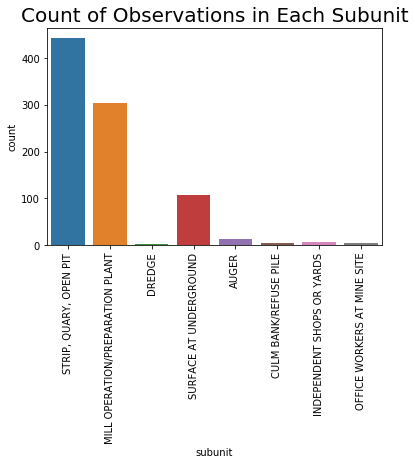

In [9]:
subunit_countplot = sb.countplot(surface_fatigue.subunit)
subunit_countplot.set_xticklabels(subunit_countplot.get_xticklabels(),rotation = 90)
plt.title("Count of Observations in Each Subunit", color = "black", fontsize=20)
plt.show()

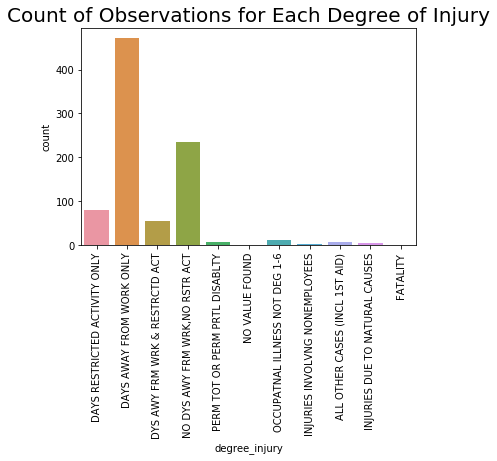

In [10]:
degree_countplot = sb.countplot(surface_fatigue.degree_injury)
degree_countplot.set_xticklabels(degree_countplot.get_xticklabels(),rotation = 90)
plt.title("Count of Observations for Each Degree of Injury", color = "black", fontsize=20)
plt.show()

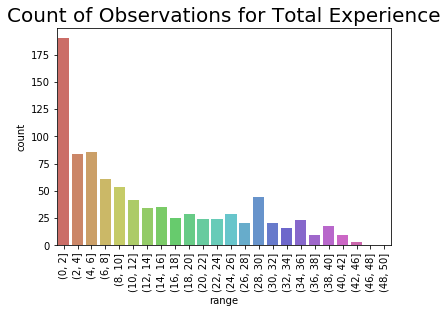

In [11]:
bin = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,46,48,50]
category = pd.cut(surface_fatigue.tot_exper,bin)
category = category.to_frame()
category.columns = ['range']
df_new = pd.concat([surface_fatigue,category],axis = 1)
tot_exper_countplot = sb.countplot(x = 'range', data = df_new, palette = 'hls')
tot_exper_countplot.set_xticklabels(tot_exper_countplot.get_xticklabels(),rotation = 90)
plt.title("Count of Observations for Total Experience", color = "black", fontsize=20)
plt.show()

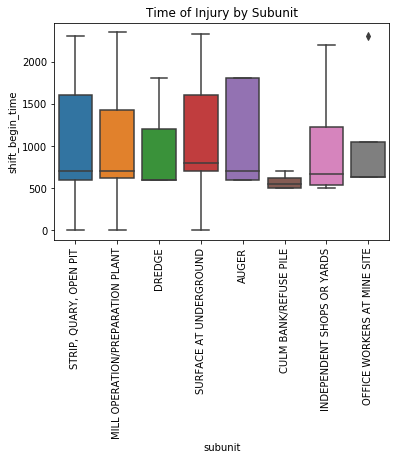

In [12]:
subunit_shiftbegin_boxplot = sb.boxplot(x='subunit', y='shift_begin_time',data=surface_fatigue[surface_fatigue.shift_begin_time < 2400])
subunit_shiftbegin_boxplot.set_xticklabels(subunit_shiftbegin_boxplot.get_xticklabels(),rotation = 90)
plt.title("Time of Injury by Subunit")
plt.show()

This shows the type of work the miner was doing when injured. We see that time of injury varies greatly for most of these workplaces, implying that different shifts are each susceptible to injury.

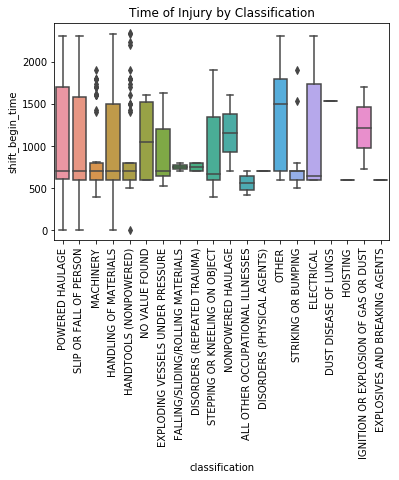

In [15]:
subunit_shiftbegin_boxplot = sb.boxplot(x='classification', y='shift_begin_time',data=surface_fatigue[surface_fatigue.shift_begin_time < 2400])
subunit_shiftbegin_boxplot.set_xticklabels(subunit_shiftbegin_boxplot.get_xticklabels(),rotation =90)
plt.title("Time of Injury by Classification")
plt.show()

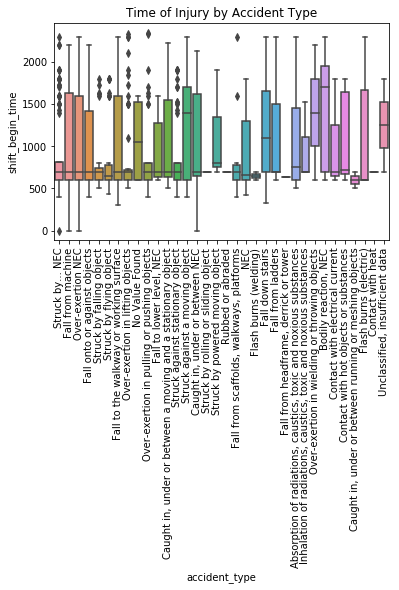

In [16]:
subunit_shiftbegin_boxplot = sb.boxplot(x='accident_type', y='shift_begin_time',data=surface_fatigue[surface_fatigue.shift_begin_time < 2400])
subunit_shiftbegin_boxplot.set_xticklabels(subunit_shiftbegin_boxplot.get_xticklabels(),rotation =90)
plt.title("Time of Injury by Accident Type")
plt.show()

This boxplot shows us an interesting variation in the number of different injury types based on the shift the miner was working. Most mines run a three shift schedule. Intuition would tell us most accidents would happen at night but we see that the means are clustered right around 8 AM. Day shift generally starts around 6 AM, so this would mean day shift is seeing the most number of accidents.

### Data Pre-Processing
Below we start importing the data that will be used for the classification and preparing it for use in those models. Useless variables have already been stripped in R before import; this code is dummy coding the categorical variables and changing the variable type so that the models don't complain. Afterwards we split the data into 75/25% test/train datasets.

In [18]:
surface_fatigue = pd.read_csv("https://www.dropbox.com/s/umqasef1hc6c9yb/totexp.csv?dl=1")
surface_fatigue = surface_fatigue.drop('Unnamed: 0',axis=1)
surface_fatigue = surface_fatigue.drop('operator_id',axis=1)
surface_fatigue.head()
surface_fatigue.dtypes

controller_name      object
operator_name        object
subunit              object
cal_yr                int64
cal_qtr               int64
accident_time         int64
degree_injury        object
fips_state_cd         int64
mining_equip         object
shift_begin_time      int64
classification       object
accident_type        object
no_injuries           int64
tot_exper             int64
mine_exper          float64
job_exper           float64
occupation           object
activity             object
injury_source        object
nature_injury        object
inj_body_part        object
schedule_charge       int64
days_restrict         int64
days_lost             int64
trans_term           object
immed_notify         object
dtype: object

In [19]:
surface_objects = surface_fatigue.select_dtypes(include=[object])
surface_fatigue = surface_fatigue.drop(surface_objects, axis=1)
surface_fatigue.shape

(883, 12)

In [20]:
surface_dummies = pd.get_dummies(surface_objects)
surface_dummies.shape

(883, 1076)

In [21]:
surface_fatigue = pd.concat([surface_fatigue, surface_dummies],axis=1)
surface_fatigue.tot_exper = surface_fatigue.tot_exper.astype(int) 
surface_fatigue.shape

(883, 1088)

In [22]:
surface_fatigue.dtypes

cal_yr                                                                    int64
cal_qtr                                                                   int64
accident_time                                                             int64
fips_state_cd                                                             int64
shift_begin_time                                                          int64
no_injuries                                                               int64
tot_exper                                                                 int32
mine_exper                                                              float64
job_exper                                                               float64
schedule_charge                                                           int64
days_restrict                                                             int64
days_lost                                                                 int64
controller_name_A J  Taft               

In [23]:
X_surface_fatigue = surface_fatigue.drop('days_lost',axis=1)
X_surface_fatigue.shape

(883, 1087)

In [24]:
X_surface_fatigue = surface_fatigue.drop('days_lost',axis=1)
y_surface_fatigue = surface_fatigue['days_lost']
X_train, X_test, y_train, y_test = train_test_split(X_surface_fatigue,y_surface_fatigue, random_state=366)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_surface_fatigue,y_surface_fatigue, random_state=366)
y_test.shape

(221L,)

## Logistic Regression
To try and improve these ratings, I've tried to fine tune the model by playing with the cache size of the model.

Training set score: 1.00
Test set score: 0.95
Number of features used: 943


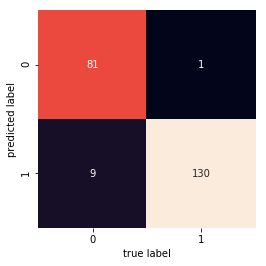

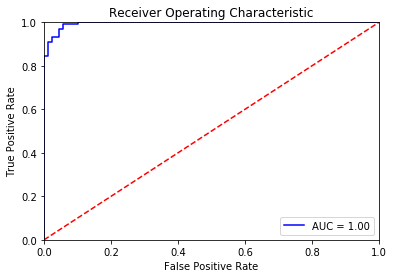

In [26]:
lr = LogisticRegression()
lr.fit(X_train,y_train)
print("Training set score: {:.2f}".format(lr.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lr.score(X_test, y_test)))
print("Number of features used: {}".format(np.sum(lr.coef_ != 0)))
ypred = lr.predict(X_test)
mat = confusion_matrix(y_test, ypred)
sb.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.show()
probs = lr.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

That's not very interesting, this may be a case where a large proportion of them did not have days lost associated with them. We'll look and see what those counts look like.

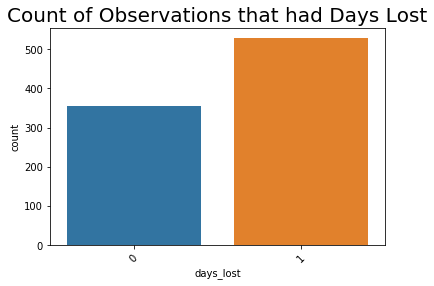

In [27]:
days_lost_countplot = sb.countplot(surface_fatigue.days_lost)
days_lost_countplot.set_xticklabels(days_lost_countplot.get_xticklabels(),rotation = 45)
plt.title("Count of Observations that had Days Lost", color = "black", fontsize=20)
plt.show()

I guess it is interesting after all. I'll keep with the process for shits and giggles through all of the processes.

Training set score: 0.94
Test set score: 0.78
Number of features used: 943


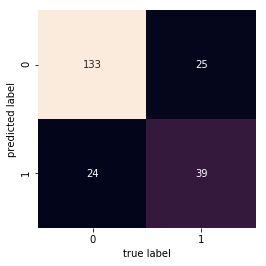

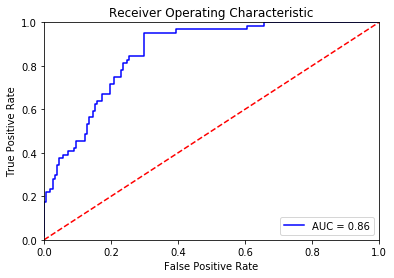

In [28]:
X_surface_fatigue = surface_fatigue.drop('tot_exper',axis=1)
X_surface_fatigue.shape
y_surface_fatigue = surface_fatigue['tot_exper']
y_surface_fatigue.shape
X_train, X_test, y_train, y_test = train_test_split(X_surface_fatigue,y_surface_fatigue, random_state=366)
lr = LogisticRegression()
lr.fit(X_train,y_train)
print("Training set score: {:.2f}".format(lr.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lr.score(X_test, y_test)))
print("Number of features used: {}".format(np.sum(lr.coef_ != 0)))
ypred = lr.predict(X_test)
mat = confusion_matrix(y_test, ypred)
sb.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.show()
probs = lr.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## k-Nearest Neighbors  


Train set predictions n = 2: [0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 1 0 1 0 1 0 0 0 0 0 1 1 1 1 1 0
 1 0 0 1 0 0 0 1 1 0 1 1 0 0 1 0 0 1 0 1 0 0 1 1 1 1 1 1 1 0 1 1 0 1 1 0 0
 1 1 1 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 1 0 0 1 0 0 1 0 1 0 1 0 0 1 0 0 1
 1 0 1 1 0 1 1 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1
 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 0 1 0 0 1 0 1 1 1
 0 1 1 1 0 0 1 0 0 0 0 0 1 1 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0
 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 1 1
 0 1 0 0 0 0 0 1 1 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 1
 0 1 1 0 1 0 1 1 1 0 1 0 1 1 1 1 0 0 1 0 0 1 0 0 1 1 1 1 0 0 0 0 0 1 0 1 0
 1 1 0 1 0 0 1 0 0 1 1 0 1 0 0 0 0 0 0 0 1 1 0 1 1 1 0 0 1 1 1 0 0 1 0 1 0
 0 0 1 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 0 1 0 0
 0 0 1 0 0 1 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 1 0 1 1 1 0 1 1 1 0 0 0 1 0
 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 1 1 1 1 

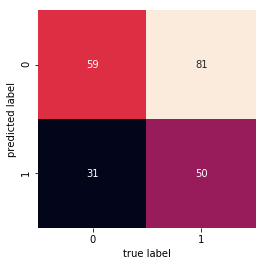

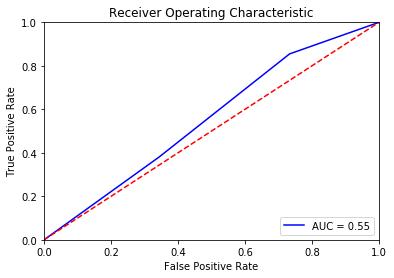

In [29]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=2)
X_surface_fatigue = surface_fatigue.drop('days_lost',axis=1)
y_surface_fatigue = surface_fatigue['days_lost']
X_train, X_test, y_train, y_test = train_test_split(X_surface_fatigue,y_surface_fatigue, random_state=366)
clf.fit(X_train, y_train)
print("Train set predictions n = 2: {}".format(clf.predict(X_train)))
print("Train set accuracy n = 2: {:.2f}".format(clf.score(X_train, y_train)))
print("Test set predictions n = 2: {}".format(clf.predict(X_test)))
print("Test set accuracy n = 2: {:.2f}".format(clf.score(X_test, y_test)))
ypred = clf.predict(X_test)
mat = confusion_matrix(y_test, ypred)
sb.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()
probs = clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Train set predictions n = 2: [0 0 0 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 0 0
 0 1 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1
 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0
 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 1 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0
 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1
 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 1 1 0
 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0
 0 1 1 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 1
 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0
 1 0 0 0 0 0 0 1 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 

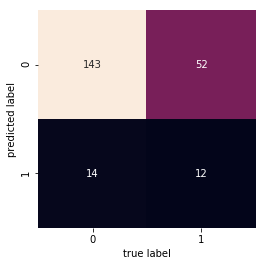

NameError: name 'predict_proba' is not defined

In [30]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=2)
X_surface_fatigue = surface_fatigue.drop('tot_exper',axis=1)
y_surface_fatigue = surface_fatigue['tot_exper']
X_train, X_test, y_train, y_test = train_test_split(X_surface_fatigue,y_surface_fatigue, random_state=366)
clf.fit(X_train, y_train)
print("Train set predictions n = 2: {}".format(clf.predict(X_train)))
print("Train set accuracy n = 2: {:.2f}".format(clf.score(X_train, y_train)))
print("Test set predictions n = 2: {}".format(clf.predict(X_test)))
print("Test set accuracy n = 2: {:.2f}".format(clf.score(X_test, y_test)))
ypred = clf.predict(X_test)
mat = confusion_matrix(y_test, ypred)
sb.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()
probs = clf
predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Simple Decision Trees

Playing with the depth at which decisions can be made (avoiding going too deep because my computer may explode), with max decision depths of 10 and 100.

Accuracy on training set depth = 10: 1.000
Accuracy on test set depth = 10: 0.986


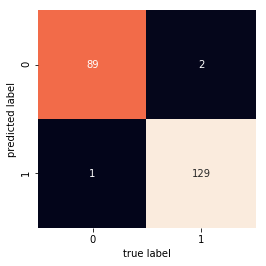

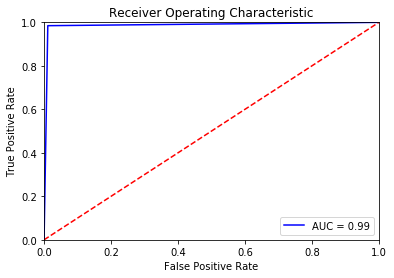

In [31]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=10,random_state=0)
X_surface_fatigue = surface_fatigue.drop('days_lost',axis=1)
y_surface_fatigue = surface_fatigue['days_lost']
X_train, X_test, y_train, y_test = train_test_split(X_surface_fatigue,y_surface_fatigue, random_state=366)
tree.fit(X_train, y_train)
print("Accuracy on training set depth = 10: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set depth = 10: {:.3f}".format(tree.score(X_test, y_test)))
ypred = tree.predict(X_test)
mat = confusion_matrix(y_test, ypred)
sb.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()
probs = tree.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Accuracy on training set depth = 100: 1.000
Accuracy on test set depth = 100: 0.828


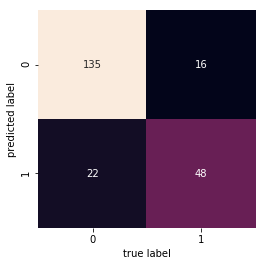

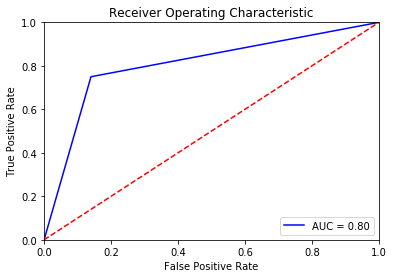

In [33]:
from sklearn.tree import DecisionTreeClassifier
tree100 = DecisionTreeClassifier(max_depth=100,random_state=0)
X_surface_fatigue = surface_fatigue.drop('tot_exper',axis=1)
y_surface_fatigue = surface_fatigue['tot_exper']
X_train, X_test, y_train, y_test = train_test_split(X_surface_fatigue,y_surface_fatigue, random_state=366)
tree100.fit(X_train, y_train)
print("Accuracy on training set depth = 100: {:.3f}".format(tree100.score(X_train, y_train)))
print("Accuracy on test set depth = 100: {:.3f}".format(tree100.score(X_test, y_test)))
ypred = tree100.predict(X_test)
mat = confusion_matrix(y_test, ypred)
sb.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()
probs = tree100.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Random Forest Classifier   
Building on our decision trees, we can average together what multiple decision trees have found. To keep our trees from digressing too far away from what the day is showing, the testing training set is bootstrapped and randomly sampled. A tree is then built on that bootstrapped data. A second tree is built on a second random sampling of the bootstrapped data, with replacement from the first sampling though. This way the second tree isn't left with only the least likely choices that weren't picked from the first sampling. The success rates between trees are averaged and given in the results of the code blocks below. All trees have been allowed to keep branching until leaves are pure (can't branch any further, we've run out of decisions). Number of trees in the forest are 5, 10, and 100 respectively for the following code blocks.

Accuracy on training set # of trees = 10: 1.000
Accuracy on test set # of trees = 10: 0.964


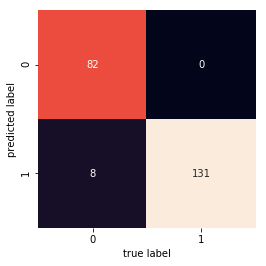

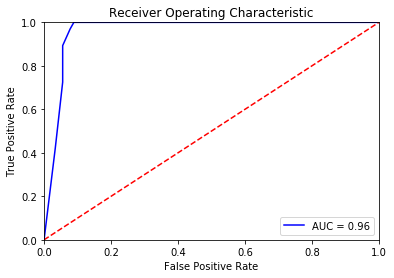

In [34]:
from sklearn.ensemble import RandomForestClassifier
forest10 = RandomForestClassifier(n_estimators=10, random_state=2)
X_surface_fatigue = surface_fatigue.drop('days_lost',axis=1)
y_surface_fatigue = surface_fatigue['days_lost']
X_train, X_test, y_train, y_test = train_test_split(X_surface_fatigue,y_surface_fatigue, random_state=366)
forest10.fit(X_train, y_train)
print("Accuracy on training set # of trees = 10: {:.3f}".format(forest10.score(X_train, y_train)))
print("Accuracy on test set # of trees = 10: {:.3f}".format(forest10.score(X_test, y_test)))
ypred = forest10.predict(X_test)
mat = confusion_matrix(y_test, ypred)
sb.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()
probs = forest10.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Accuracy on training set # of trees = 10: 0.989
Accuracy on test set # of trees = 10: 0.787


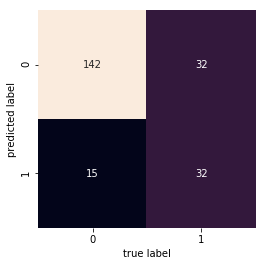

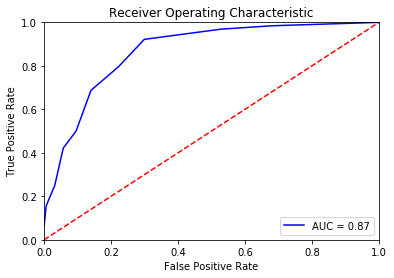

In [35]:
forest10 = RandomForestClassifier(n_estimators=10, random_state=2)
X_surface_fatigue = surface_fatigue.drop('tot_exper',axis=1)
y_surface_fatigue = surface_fatigue['tot_exper']
X_train, X_test, y_train, y_test = train_test_split(X_surface_fatigue,y_surface_fatigue, random_state=366)
forest10.fit(X_train, y_train)
print("Accuracy on training set # of trees = 10: {:.3f}".format(forest10.score(X_train, y_train)))
print("Accuracy on test set # of trees = 10: {:.3f}".format(forest10.score(X_test, y_test)))
ypred = forest10.predict(X_test)
mat = confusion_matrix(y_test, ypred)
sb.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()
probs = forest10.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Neural Networks

Accuracy on training set: 0.45
Accuracy on test set: 0.46


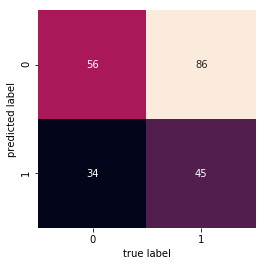

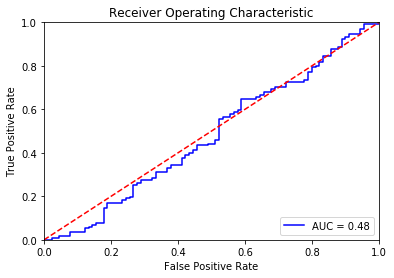

In [36]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(solver='lbfgs', random_state=0).fit(X_train, y_train)
X_surface_fatigue = surface_fatigue.drop('days_lost',axis=1)
y_surface_fatigue = surface_fatigue['days_lost']
X_train, X_test, y_train, y_test = train_test_split(X_surface_fatigue,y_surface_fatigue, random_state=366)
print("Accuracy on training set: {:.2f}".format(mlp.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(mlp.score(X_test, y_test)))
ypred = mlp.predict(X_test)
mat = confusion_matrix(y_test, ypred)
sb.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()
probs = mlp.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Not very satisfied with this, think this can do better. Playing with the "solver" and the number of hidden layers may improve this. This first code block will have 3 hidden layers with 96 (the number of variables in our data set) nodes in each.

Accuracy on training set: 0.47
Accuracy on test set: 0.41


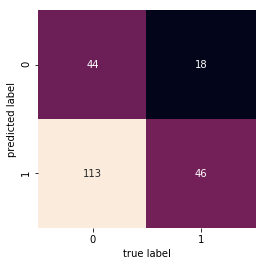

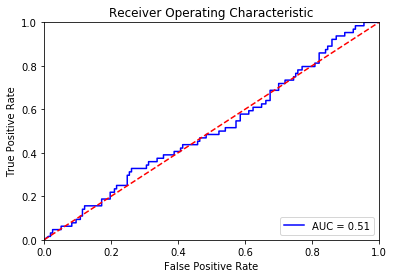

In [37]:
mlp = MLPClassifier(solver='lbfgs',hidden_layer_sizes=(96,96,96), random_state=0).fit(X_train, y_train)
X_surface_fatigue = surface_fatigue.drop('tot_exper',axis=1)
y_surface_fatigue = surface_fatigue['tot_exper']
X_train, X_test, y_train, y_test = train_test_split(X_surface_fatigue,y_surface_fatigue, random_state=366)
print("Accuracy on training set: {:.2f}".format(mlp.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(mlp.score(X_test, y_test)))
ypred = mlp.predict(X_test)
mat = confusion_matrix(y_test, ypred)
sb.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()
probs = mlp.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Increasing the hidden layers seems to not be doing much and it's much taking longer for the computer to calculate it as well.

## Naive-Bayes
We'll look at the Gaussian and Bernoulli version of the Naive-Bayes classification. Since the data in this first problem is more often than not binary, the Bernoulli version should be best since, as the name implies, it uses a Bernoulli distribution to find the probability of being classified as one or the other.

### Gaussian Naive-Bayes

Accuracy on training set: 0.98
Accuracy on test set: 0.98
Number of features used: 943


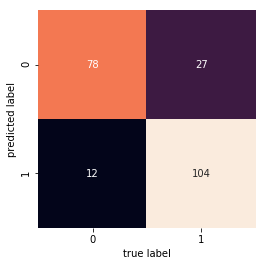

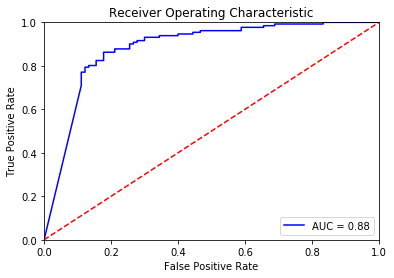

In [38]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
gnb = GaussianNB()
X_surface_fatigue = surface_fatigue.drop('days_lost',axis=1)
y_surface_fatigue = surface_fatigue['days_lost']
X_train, X_test, y_train, y_test = train_test_split(X_surface_fatigue,y_surface_fatigue, random_state=366)
gnb.fit(X_train, y_train)
print("Accuracy on training set: {:.2f}".format(gnb.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(gnb.score(X_train, y_train)))
print("Number of features used: {}".format(np.sum(lr.coef_ != 0)))
ypred = gnb.predict(X_test)
mat = confusion_matrix(y_test, ypred)
sb.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()
probs = gnb.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Accuracy on training set: 0.91
Accuracy on test set: 0.91
Number of features used: 943


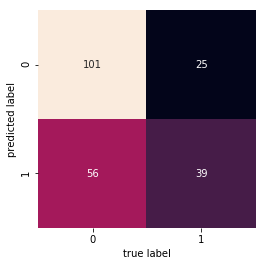

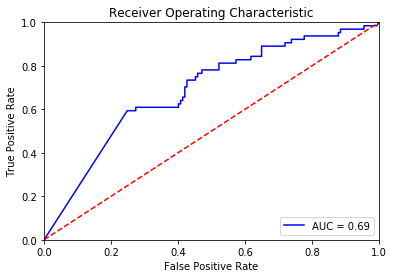

In [39]:
gnb = GaussianNB()
X_surface_fatigue = surface_fatigue.drop('tot_exper',axis=1)
y_surface_fatigue = surface_fatigue['tot_exper']
X_train, X_test, y_train, y_test = train_test_split(X_surface_fatigue,y_surface_fatigue, random_state=366)
gnb.fit(X_train, y_train)
print("Accuracy on training set: {:.2f}".format(gnb.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(gnb.score(X_train, y_train)))
print("Number of features used: {}".format(np.sum(lr.coef_ != 0)))
ypred = gnb.predict(X_test)
mat = confusion_matrix(y_test, ypred)
sb.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()
probs = gnb.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Bernoulli Naive-Bayes

Accuracy on training set: 0.97
Accuracy on test set: 0.97


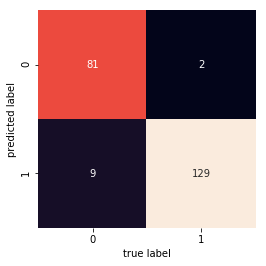

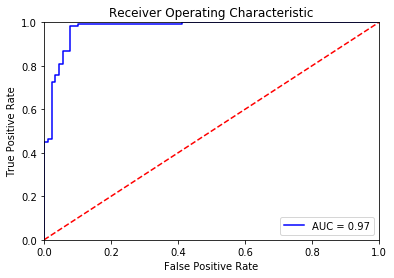

In [40]:
bnb = BernoulliNB()
X_surface_fatigue = surface_fatigue.drop('days_lost',axis=1)
y_surface_fatigue = surface_fatigue['days_lost']
X_train, X_test, y_train, y_test = train_test_split(X_surface_fatigue,y_surface_fatigue, random_state=366)
bnb.fit(X_train, y_train)
print("Accuracy on training set: {:.2f}".format(bnb.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(bnb.score(X_train, y_train)))
ypred = bnb.predict(X_test)
mat = confusion_matrix(y_test, ypred)
sb.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()
probs = bnb.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Accuracy on training set: 0.83
Accuracy on test set: 0.83


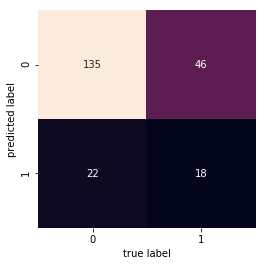

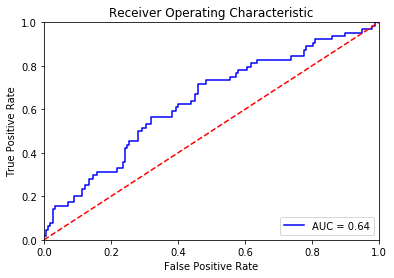

In [41]:
bnb = BernoulliNB()
X_surface_fatigue = surface_fatigue.drop('tot_exper',axis=1)
y_surface_fatigue = surface_fatigue['tot_exper']
X_train, X_test, y_train, y_test = train_test_split(X_surface_fatigue,y_surface_fatigue, random_state=366)
bnb.fit(X_train, y_train)
print("Accuracy on training set: {:.2f}".format(bnb.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(bnb.score(X_train, y_train)))
ypred = bnb.predict(X_test)
mat = confusion_matrix(y_test, ypred)
sb.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()
probs = bnb.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## SVM (Support Vector Machines)

Accuracy on training set linear kernel: 1.00
Accuracy on test set linear kernel: 1.00


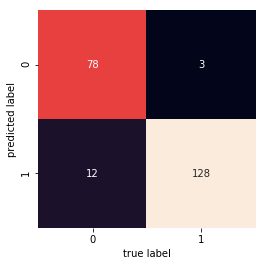

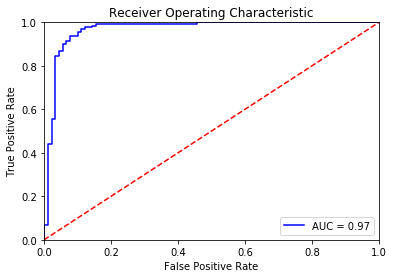

In [42]:
from sklearn.svm import SVC
lsvcclassifier = SVC(kernel='linear',probability=True)
X_surface_fatigue = surface_fatigue.drop('days_lost',axis=1)
y_surface_fatigue = surface_fatigue['days_lost']
X_train, X_test, y_train, y_test = train_test_split(X_surface_fatigue,y_surface_fatigue, random_state=366)
lsvcclassifier.fit(X_train, y_train)
print("Accuracy on training set linear kernel: {:.2f}".format(lsvcclassifier.score(X_train, y_train)))
print("Accuracy on test set linear kernel: {:.2f}".format(lsvcclassifier.score(X_train, y_train)))
ypred = lsvcclassifier.predict(X_test)
mat = confusion_matrix(y_test, ypred)
sb.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()
probs = lsvcclassifier.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Accuracy on training set linear kernel: 0.89
Accuracy on test set linear kernel: 0.89


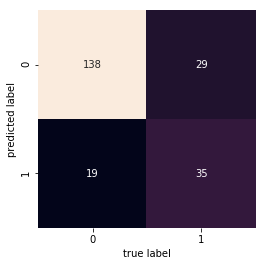

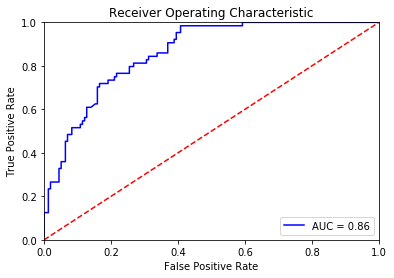

In [43]:
lsvcclassifier = SVC(kernel='linear',probability=True)
X_surface_fatigue = surface_fatigue.drop('tot_exper',axis=1)
y_surface_fatigue = surface_fatigue['tot_exper']
X_train, X_test, y_train, y_test = train_test_split(X_surface_fatigue,y_surface_fatigue, random_state=366)
lsvcclassifier.fit(X_train, y_train)
print("Accuracy on training set linear kernel: {:.2f}".format(lsvcclassifier.score(X_train, y_train)))
print("Accuracy on test set linear kernel: {:.2f}".format(lsvcclassifier.score(X_train, y_train)))
ypred = lsvcclassifier.predict(X_test)
mat = confusion_matrix(y_test, ypred)
sb.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()
probs = lsvcclassifier.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Continuous Variable Prediction

Gonna see if we can't get close to predicting someone's total experience based on the injury they've sustained.

In [ ]:
surface_fatigue = pd.read_csv("https://www.dropbox.com/s/umqasef1hc6c9yb/totexp.csv?dl=")
surface_fatigue = surface_fatigue.drop('Unnamed: 0',axis=1)
surface_fatigue = surface_fatigue.drop('operator_id',axis=1)
surface_fatigue.head()

In [ ]:
surface_fatigue.shape

In [ ]:
surface_objects = surface_fatigue.select_dtypes(include=[object])
surface_fatigue = surface_fatigue.drop(surface_objects, axis=1)
surface_fatigue.shape

In [ ]:
surface_dummies = pd.get_dummies(surface_objects)
surface_dummies.shape

In [ ]:
surface_fatigue = pd.concat([surface_fatigue, surface_dummies],axis=1)
surface_fatigue.tot_exper = surface_fatigue.tot_exper.astype(int) 
surface_fatigue.shape

In [ ]:
surface_fatigue.dtypes

### Lasso Regression

In [ ]:
X_surface_fatigue = surface_fatigue.drop('tot_exper',axis=1)
y_surface_fatigue = surface_fatigue['tot_exper']
X_train, X_test, y_train, y_test = train_test_split(X_surface_fatigue,y_surface_fatigue, random_state=366)

lasso = Lasso().fit(X_train, y_train)
print("Training set score: {:.2f}".format(lasso.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lasso.score(X_test, y_test)))
print("Number of features used: {}".format(np.sum(lasso.coef_ != 0)))

In [ ]:
scores = cross_val_score(lasso, X_surface_fatigue, y_surface_fatigue, cv=10)
print("Average cross-validation score: {:.2f}".format(scores.mean()))

### Ridge Regression

In [ ]:
ridge = Ridge().fit(X_train, y_train)
print("Training set score: {:.2f}".format(ridge.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ridge.score(X_test, y_test)))
scores = cross_val_score(ridge, X_surface_fatigue, y_surface_fatigue, cv=10)
print("Average cross-validation score: {:.2f}".format(scores.mean()))

### Linear Regression

In [ ]:
lr = LinearRegression().fit(X_train, y_train)
print("Training set score: {:.2f}".format(lr.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lr.score(X_test, y_test)))
scores = cross_val_score(lr, X_surface_fatigue, y_surface_fatigue, cv=10)
print("Average cross-validation score: {:.2f}".format(scores.mean()))

# Clustering
We try and see if we can't cluster the years experience into five categories; ranges of amount of time in industry from 0-2, 2-4, 4-6, 6-10, and > 10 years. All methods will be summarised at the end, including which model performed the best. Categorization of "tot_exper" was done in R, the .csv output of which was loaded in this next section.

### Pre-Processing Categorized "tot_exper" Dataset 

In [136]:
surface_fatigue2 = pd.read_csv("https://www.dropbox.com/s/10yc3xprdt12og9/totexpcats.csv?dl=1")
surface_fatigue2 = surface_fatigue2.drop('Unnamed: 0',axis=1)
surface_fatigue2 = surface_fatigue2.drop('operator_id',axis=1)
surface_fatigue2.head()

,controller_name,operator_name,subunit,cal_yr,cal_qtr,accident_time,degree_injury,fips_state_cd,mining_equip,shift_begin_time,...,occupation,activity,injury_source,nature_injury,inj_body_part,schedule_charge,days_restrict,days_lost,trans_term,immed_notify
0,Roger Krause,Krause Bros Construction,"STRIP, QUARY, OPEN PIT",2012,2,1420,DAYS RESTRICTED ACTIVITY ONLY,38,"Front-end loader, Tractor-shovel, Payloader, H...",700,...,"Laborer, Blacksmith, Bull gang, Parts runner, ...",Observe operations,"CHAIN,ROPE,CABLE-NT CONVY","CONTUSN,BRUISE,INTAC SKIN",BACK (MUSCLES/SPINE/S-CORD/TAILBONE),0,4,0,N,NO VALUE FOUND
1,Titan Cement Company S A,"Roanoke Cement Co., LLC",MILL OPERATION/PREPARATION PLANT,2012,2,1100,DAYS AWAY FROM WORK ONLY,51,"Front-end loader, Tractor-shovel, Payloader, H...",700,...,"Ledgeman/hand, Quarry man",Getting on or off equipment,SURFACE MINING MACHINES,"FRACTURE,CHIP",LOWER LEG/TIBIA/FIBULA,0,0,158,N,NO VALUE FOUND
2,Kathy L Dimmerling,Christman Quarry,"STRIP, QUARY, OPEN PIT",2007,1,1130,DAYS AWAY FROM WORK ONLY,39,NO VALUE FOUND,700,...,Haul/Off road/Coal/Ore/Pit/Quarry/Rock/Rubber ...,Handling explosives,GROUND,"FRACTURE,CHIP",ANKLE,0,0,15,N,NO VALUE FOUND
3,Lafarge S A,Lafarge North America Inc.,MILL OPERATION/PREPARATION PLANT,2012,4,1530,DYS AWY FRM WRK & RESTRCTD ACT,39,NO VALUE FOUND,1500,...,"Warehouseman, Bagger, Palletizer/Stacker, Stor...",Handling supplies or material,"FLOOR,WALKING SURF-NOT UG","SPRAIN,STRAIN RUPT DISC",SHOULDERS (COLLARBONE/CLAVICLE/SCAPULA),0,12,167,N,NO VALUE FOUND
4,Italcementi Spa,Essroc Cement Corporation,MILL OPERATION/PREPARATION PLANT,2013,2,1350,"NO DYS AWY FRM WRK,NO RSTR ACT",42,"Rock drill, Jackleg, Airleg, Drifter, Stoper, ...",700,...,"Laborer, Blacksmith, Bull gang, Parts runner, ...",Hand tools (powered),"DRIL-PRCUSV,HRD ROC,JKHMR","CONTUSN,BRUISE,INTAC SKIN",FOOT(NOT ANKLE/TOE)/TARSUS/METATARSUS,0,0,0,N,NO VALUE FOUND


In [137]:
surface_objects2 = surface_fatigue2.select_dtypes(include=[object])
surface_fatigue2 = surface_fatigue2.drop(surface_objects, axis=1)
surface_dummies2 = pd.get_dummies(surface_objects2)
surface_fatigue2 = pd.concat([surface_fatigue2, surface_dummies2],axis=1)
surface_fatigue2.tot_exper = surface_fatigue2.tot_exper.astype(int) 

In [138]:
surface_fatigue2.shape

(883, 1088)

In [139]:
surface_fatigue2.head()

,cal_yr,cal_qtr,accident_time,fips_state_cd,shift_begin_time,no_injuries,tot_exper,mine_exper,job_exper,schedule_charge,...,inj_body_part_WRIST,trans_term_N,trans_term_Y,immed_notify_DEATH,immed_notify_GAS OF DUST IGNITION,immed_notify_HOISTING,immed_notify_NO VALUE FOUND,immed_notify_NOT MARKED,immed_notify_OFFSITE INJURY,immed_notify_SERIOUS INJURY
0,2012,2,1420,38,700,1,1,5.00,5.00,0,...,0,1,0,0,0,0,1,0,0,0
1,2012,2,1100,51,700,1,2,9.00,9.00,0,...,0,1,0,0,0,0,1,0,0,0
2,2007,1,1130,39,700,1,0,2.46,2.46,0,...,0,1,0,0,0,0,1,0,0,0
3,2012,4,1530,39,1500,1,1,7.00,7.00,0,...,0,1,0,0,0,0,1,0,0,0
4,2013,2,1350,42,700,1,3,18.31,7.31,0,...,0,1,0,0,0,0,1,0,0,0


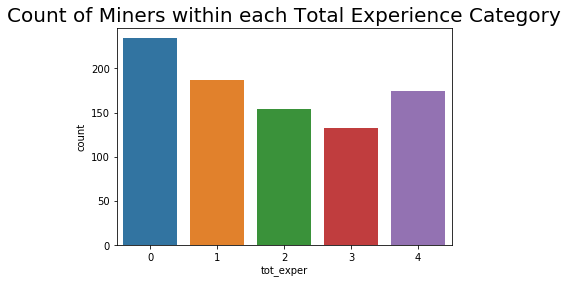

In [140]:
tot_exper_countplot = sb.countplot(surface_fatigue2.tot_exper)
tot_exper_countplot.set_xticklabels(tot_exper_countplot.get_xticklabels(),rotation = 0)
plt.title("Count of Miners within each Total Experience Category", color = "black", fontsize=20)
plt.show()

### K-Nearest Neighbor

Train set predictions n = 5: [0 3 0 0 0 2 2 2 0 0 1 1 0 4 0 1 4 4 4 2 0 4 3 0 1 0 4 0 0 0 1 4 0 0 1 2 4
 4 0 4 1 3 0 0 0 2 4 4 3 0 0 2 1 4 2 4 4 0 0 1 4 0 0 0 3 0 0 3 2 0 1 3 0 1
 2 0 0 2 1 0 0 3 2 0 1 1 0 2 0 0 0 0 0 0 0 4 3 3 0 0 1 0 4 3 2 0 4 2 4 3 3
 1 3 1 2 2 4 1 4 0 1 0 0 1 4 3 0 0 0 1 4 1 1 2 1 0 0 0 1 1 0 0 1 1 0 1 0 2
 0 4 4 0 3 1 1 0 0 4 3 0 0 2 0 0 0 4 0 4 0 4 3 0 0 3 2 3 0 2 2 0 0 3 1 0 2
 1 0 4 2 2 1 3 1 1 1 0 2 4 0 0 2 1 0 1 3 4 0 1 1 0 2 0 0 0 0 2 3 0 1 0 4 0
 1 3 2 2 0 1 0 0 0 2 0 0 0 4 2 0 3 1 4 0 0 3 2 2 0 0 4 1 0 2 0 0 1 4 0 1 0
 1 0 1 1 3 2 0 0 3 4 0 0 0 0 4 0 2 3 0 2 1 0 0 1 0 4 0 2 0 2 3 0 1 0 0 0 0
 0 3 2 0 1 0 2 0 0 0 0 1 0 3 0 0 3 0 0 3 3 0 0 3 0 0 0 0 0 0 4 0 1 0 0 2 1
 0 0 0 3 1 4 3 2 0 4 0 0 0 1 0 0 0 0 1 0 4 2 2 0 3 1 0 3 1 2 0 0 0 2 1 4 0
 1 0 0 1 2 0 0 0 4 3 0 0 1 0 2 2 4 0 0 1 0 4 4 0 2 1 4 2 0 0 0 3 0 0 0 0 4
 2 0 1 0 0 0 0 0 0 0 4 1 1 1 0 0 3 0 4 4 1 0 0 4 0 0 1 3 0 2 0 4 0 0 0 4 1
 0 4 3 0 4 4 1 0 0 1 4 3 2 0 0 1 0 2 0 0 1 0 0 3 1 2 1 1 4 1 0 0 0 0 1 

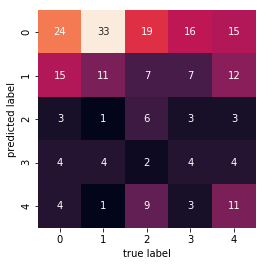

In [141]:
X_surface_fatigue2 = surface_fatigue2.drop('tot_exper',axis=1)
y_surface_fatigue2 = surface_fatigue2['tot_exper']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_surface_fatigue2,y_surface_fatigue2, random_state=366)
from sklearn.neighbors import KNeighborsClassifier
knn5 = KNeighborsClassifier(n_neighbors=5)
knn5.fit(X_train2, y_train2)
print("Train set predictions n = 5: {}".format(knn5.predict(X_train2)))
print("Train set accuracy n = 5: {:.2f}".format(knn5.score(X_train2, y_train2)))
print("Test set predictions n = 5: {}".format(knn5.predict(X_test2)))
print("Test set accuracy n = 5: {:.2f}".format(knn5.score(X_test2, y_test2)))
ypred = knn5.predict(X_test2)
mat = confusion_matrix(y_test2, ypred)
sb.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

### Decision Tree

Accuracy on training set: 1.000
Accuracy on test set: 0.633


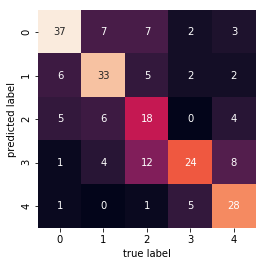

In [142]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train2, y_train2)
print("Accuracy on training set: {:.3f}".format(tree.score(X_train2, y_train2)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test2, y_test2)))
ypred = tree.predict(X_test2)
mat = confusion_matrix(y_test2, ypred)
sb.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

Accuracy on training set: 0.908
Accuracy on test set: 0.638


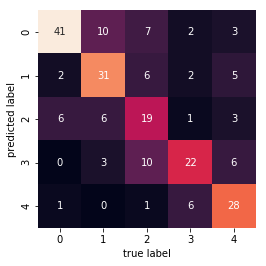

In [143]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth = 10, random_state=0)
tree.fit(X_train2, y_train2)
print("Accuracy on training set: {:.3f}".format(tree.score(X_train2, y_train2)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test2, y_test2)))
ypred = tree.predict(X_test2)
mat = confusion_matrix(y_test2, ypred)
sb.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

Accuracy on training set: 1.000
Accuracy on test set: 0.633


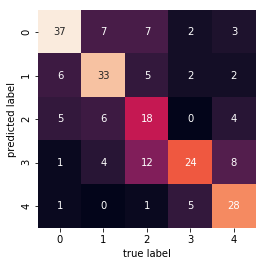

In [144]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth = 100, random_state=0)
tree.fit(X_train2, y_train2)
print("Accuracy on training set: {:.3f}".format(tree.score(X_train2, y_train2)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test2, y_test2)))
ypred = tree.predict(X_test2)
mat = confusion_matrix(y_test2, ypred)
sb.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

### Random Forest Classifier

Accuracy on training set # of trees = 5: 0.924
Accuracy on test set # of trees = 5: 0.434


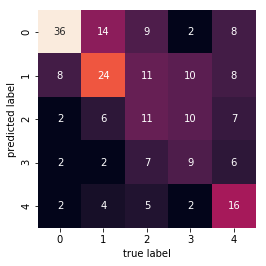

In [145]:
from sklearn.ensemble import RandomForestClassifier

forest5 = RandomForestClassifier(n_estimators=5, random_state=2)
forest5.fit(X_train2, y_train2)
print("Accuracy on training set # of trees = 5: {:.3f}".format(forest5.score(X_train2, y_train2)))
print("Accuracy on test set # of trees = 5: {:.3f}".format(forest5.score(X_test2, y_test2)))
ypred = forest5.predict(X_test2)
mat = confusion_matrix(y_test2, ypred)
sb.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

Accuracy on training set # of trees = 5: 0.949
Accuracy on test set # of trees = 5: 0.403


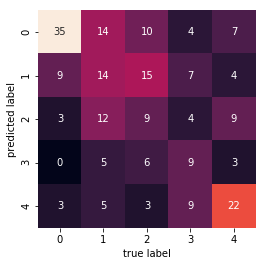

In [146]:
from sklearn.ensemble import RandomForestClassifier

forest5 = RandomForestClassifier(n_estimators=5, random_state=100)
forest5.fit(X_train2, y_train2)
print("Accuracy on training set # of trees = 5: {:.3f}".format(forest5.score(X_train2, y_train2)))
print("Accuracy on test set # of trees = 5: {:.3f}".format(forest5.score(X_test2, y_test2)))
ypred = forest5.predict(X_test2)
mat = confusion_matrix(y_test2, ypred)
sb.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

### Hierarchical Clustering

Since this is an unsupervised technique, I used the entire dataset and removed the "tot_exper" from that. I ran this dataset through Aggomerative Clustering, choosing to cut it at 5 groups, then compared what the model labeled each observation as to what it really was.

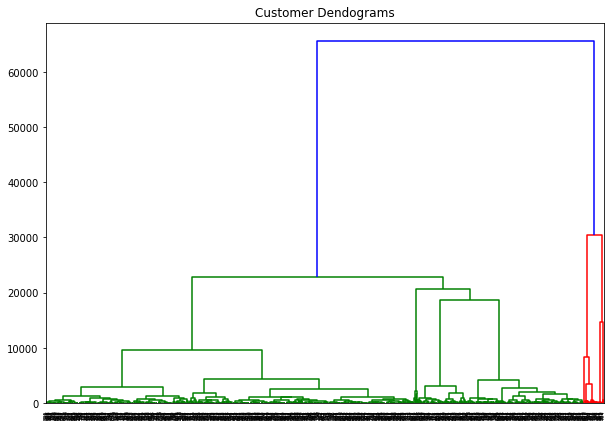

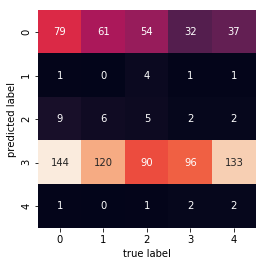

In [152]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7)) 
plt.title("Customer Dendograms")  
dend = shc.dendrogram(shc.linkage(X_surface_fatigue2, method='ward'))
plt.show()
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')  
ypred = cluster.fit_predict(X_surface_fatigue2) 
mat = confusion_matrix(y_surface_fatigue2, ypred)
sb.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

### Gaussian Mixture Models Clustering
Same as the hierarchical clustering, this is an unsupervised technique. The confusion matrix was created the same way as before as well.

C:\Users\Luke\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Luke\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Luke\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Luke\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Functio

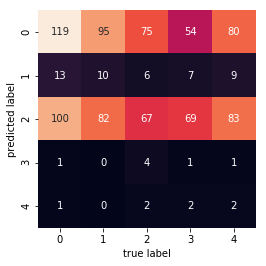

In [155]:
from sklearn.mixture import GMM
gmm = GMM(n_components=5).fit(X_surface_fatigue2)
labels = gmm.predict(X_surface_fatigue2)
mat = confusion_matrix(y_surface_fatigue2, labels)
sb.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

### Clustering Conclusion
It appears out of all of these methods for classification based on cluster, the simple decision trees performed the best. This is surprising since random forest classifiers have almost alway outperformed it's simpler form a.k.a. decision trees. Neither of the unsupervised techniques performed well. We have some strange trends in missclassification. The models tend to like putting everything into one of two classification.

In [2]:
jupyter nbconvert --to html filename.ipynb

SyntaxError: invalid syntax (<ipython-input-2-99c6a29d2203>, line 1)